In [1]:
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm


/tmp/ipykernel_284852/1348182768.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_284852/1348182768.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
# import pysvelte
# 
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

torch.set_grad_enabled(False)
device = "cpu"

In [3]:
model = HookedTransformer.from_pretrained(
    "gpt2-xl",
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=False,
    refactor_factored_attn_matrices=True,
    device=device
)

model.cfg.total_heads = model.cfg.n_heads * model.cfg.n_layers

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer


In [4]:
def query_logits(logits, return_type = "logits", TOP_N = 10):

        """
        Gets top 10 predictions after last token in a prompt
        """
        last_tok_logits = logits[0, -1]
        
        #gets probs after last tok in seq
        
        if return_type == "probs":
            scores = F.softmax(last_tok_logits, dim=-1).detach().cpu().numpy() #the [0] is to index out of the batch idx
        else:
            scores = last_tok_logits.detach().cpu().numpy()

        #assert probs add to 1
        # assert np.abs(np.sum(probs) - 1) <= 0.01, str(np.abs(np.sum(probs)-1)) 

        probs_ = []
        for index, prob in enumerate(scores):
            probs_.append((index, prob))

        top_k = sorted(probs_, key = lambda x: x[1], reverse = True)[:TOP_N]
        top_k = [(t[1].item(), model.tokenizer.decode(t[0])) for t in top_k]
        
        return top_k
    
def is_logits_contain_label(ranked_logits, correct_answer):
    # Convert correct_answer to lower case and strip white space
    correct_answer = correct_answer.strip().lower()

    # Loop through the top 10 logits
    for logit_score, logit_value in ranked_logits:
        # Convert logit_value to lower case and strip white space
        logit_value = logit_value.strip().lower()

        # Check if the correct answer contains the logit value
        if correct_answer.find(logit_value) != -1: 
            return True
    return False


In [5]:
import random
import pandas as pd
from torch.utils.data import Dataset

class CapitalsDataset(Dataset):
    def __init__(self, csv_file):
        # Load the dataset
        self.dataframe = pd.read_csv(csv_file)

    def __len__(self):
        # Return the length of the dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        #idx must be int
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the country and capital at the provided index
        country = self.dataframe.at[idx, 'country']
        capital = self.dataframe.at[idx, 'capital']

        # Format the input and label strings
        input_string = f"Q: What is the capital of {str(country)}? A:"
        label_string = f"{str(capital)}"

        # Return a dict with the input and label
        sample = {'input': input_string, 'label': label_string}
        return sample

def generate_few_shot_prompt(capitals_dataset, n_few_shot, prohibited_indices=[], prop_wrong = 0):
    # Get a list of allowed indices (all indices not in prohibited_indices)
    allowed_indices = [i for i in range(len(capitals_dataset)) if i not in prohibited_indices]

    # Ensure n_few_shot is not greater than the size of the dataset
    n_few_shot = min(n_few_shot, len(allowed_indices))

    # Randomly select n_few_shot indices from the allowed indices without replacement
    indices = random.sample(allowed_indices, n_few_shot)

    # Generate the few-shot prompt
    prompt = ""
    for index in indices:
        sample = capitals_dataset[index]
        
        if np.random.rand() < prop_wrong:
            allowed_indices = [i for i in range(len(capitals_dataset)) if i not in (prohibited_indices + [index])]

            diff_idx = random.sample(allowed_indices, 1)[0]
                        
            prompt += f"{sample['input']} {capitals_dataset[diff_idx]['label']}\n"
        else:  
            prompt += f"{sample['input']} {sample['label']}\n"
        
    return prompt

In [6]:

# Create the original dataset
capitals_dataset = CapitalsDataset(csv_file='world_capitals.csv')

# Create the new dataset
few_shot_capitals_prompts = []
n_few_shot = 5 # Set this to your desired number of few-shot examples
for i in range(len(capitals_dataset)):
    # Generate a few-shot prompt without the current index
    prompt = generate_few_shot_prompt(capitals_dataset, n_few_shot, prohibited_indices=[i])

    # Get the current sample and add the prompt to the 'input'
    sample = capitals_dataset[i]
    sample['input'] = prompt + sample['input']

    # Add the sample to the new dataset
    few_shot_capitals_prompts.append(sample)


In [ ]:
# n_correct = 0 
# for row in tqdm(few_shot_capitals_prompts):
#     prompt = row["input"]
#     label = row["label"]

#     logits = model(prompt)
    
#     ranked_logits = query_logits(logits, TOP_N = 1)
    
#     if is_logits_contain_label(ranked_logits, label):
#         n_correct +=1
#         row["model_correct"] = 1
#     else:
#         row["model_correct"] = 0
    
# n_correct / len(few_shot_capitals_prompts)

In [158]:
from sklearn.model_selection import train_test_split
from einops import repeat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score

class NumCorrectIncontextProbeDataset():
    def __init__(self, capitals_dataset, model, id: str = None, probe_id: str = None, seed = 0, acts_to_load = ["attn_head"]):
        self.capitals_dataset = capitals_dataset
        self.model = model
        
        if id is not None:
            acts_dict, self.dataset = self.load_acts_and_dataset(id, acts_to_load = acts_to_load)
            for act in acts_dict:
                if act == "attn_head":
                    self.attn_head_acts = acts_dict[act]
                if act == "mlp":
                    self.mlp_acts = acts_dict[act]
                if act == "resid":
                    self.resid_acts = acts_dict[act]      
                     
            self.labels = [sample["n_correct"] for sample in self.dataset]
        else:
            self.dataset = self.gen_dataset()
            self.labels = [sample["n_correct"] for sample in self.dataset]
            self.attn_head_acts = []
            self.mlp_acts = []
            self.resid_acts = []
            
        if probe_id is not None:
            self.probes = torch.load(f"activations/{probe_id}.pkl")
        
        np.random.seed(seed)
        torch.manual_seed(seed)        
        
    def generate_few_shot_prompt_wrong(self, n_few_shot, prohibited_index, prop_wrong = 0):
        # Get a list of allowed indices (all indices not in prohibited_indices)
        allowed_indices = [i for i in range(len(capitals_dataset)) if i not in [prohibited_index]]

        # Ensure n_few_shot is not greater than the size of the dataset
        n_few_shot = min(n_few_shot, len(allowed_indices))

        # Randomly select n_few_shot indices from the allowed indices without replacement
        indices = random.sample(allowed_indices, n_few_shot)

        # Generate the few-shot prompt
        prompt = ""
        n_correct = 0
        for index in indices:
            sample = self.capitals_dataset[index]
            
            if np.random.rand() < prop_wrong:
                allowed_indices = [i for i in range(len(capitals_dataset)) if i not in ([prohibited_index] + [index])]

                diff_idx = random.sample(allowed_indices, 1)[0]
                            
                prompt += f"{sample['input']} {capitals_dataset[diff_idx]['label']}\n"
            else:  
                prompt += f"{sample['input']} {sample['label']}\n"
                n_correct += 1
                
        return prompt, n_correct
    
    def gen_dataset(self, n_few_shot: int = 5):
        dataset = []
        for i in range(len(self.capitals_dataset)):
            # Generate a few-shot prompt without the current index
            # n_few_shot = np.random.randint(10)
            
            prop_wrong = np.random.rand()
            prompt, n_correct = self.generate_few_shot_prompt_wrong(n_few_shot, prohibited_index = i, prop_wrong = prop_wrong)

            # Get the current sample and add the prompt to the 'input'
            sample = self.capitals_dataset[i]
            sample['input'] = prompt + sample['input']
            sample['n_few_shot'] = n_few_shot
            sample["prop_wrong"] = prop_wrong
            sample['n_correct'] = n_correct
        
            # Add the sample to the new dataset
            dataset.append(sample)
        
        return dataset
        
    def gen_attn_head_acts(self, store_acts = True, filepath = "activations/", id = None):
        for sample in tqdm(self.dataset):
            prompt = sample["input"]
            label = sample["label"]
            
            original_logits, cache = self.model.run_with_cache(prompt)

            ranked_logits = query_logits(original_logits, TOP_N = 1)
            
            if is_logits_contain_label(ranked_logits, label):
                sample["model_correct"] = 1
            else:
                sample["model_correct"] = 0
                
        
        if store_acts:
            if id is None:
                id = np.random.randint(10000)
            torch.save(self.attn_head_acts, f'{filepath}{id}_attn_head_acts.pt')
            torch.save(self.dataset, f'{filepath}{id}_dataset.pkl')
            print(f"Stored at {id}")
        
        return self.attn_head_acts
    
    def gen_acts(self, store_acts = True, act_types: List = ["attn_out", "mlp_out", "resid_post"], filepath = "activations/", id = None):
        for sample in tqdm(self.dataset):
            prompt = sample["input"]
            label = sample["label"]
            
            original_logits, cache = self.model.run_with_cache(prompt)

            ranked_logits = query_logits(original_logits, TOP_N = 1)
            
            if is_logits_contain_label(ranked_logits, label):
                sample["model_correct"] = 1
            else:
                sample["model_correct"] = 0
            
            for act in act_types:
                if act == "mlp_out":
                    self.mlp_acts.append(cache.stack_activation(act)[:, 0, -1].numpy())
                elif act == "resid_post":
                    self.resid_acts.append(cache.stack_activation(act)[:, 0, -1].numpy())
                elif act == "attn_out":
                    self.attn_head_acts.append(cache.stack_head_results(layer = -1, pos_slice = -1).squeeze(1).numpy())
                    
        if store_acts:
            if id is None:
                id = np.random.randint(10000)
            torch.save(self.resid_acts, f'{filepath}{id}_resid_acts.pt')
            torch.save(self.mlp_acts, f'{filepath}{id}_mlp_acts.pt')
            torch.save(self.attn_head_acts, f'{filepath}{id}_attn_head_acts.pt')

            torch.save(self.dataset, f'{filepath}{id}_dataset.pkl')

            print(f"Stored at {id}")
        
        return self.attn_head_acts, self.mlp_acts, self.resid_acts
    
    def load_acts_and_dataset(self, id, filepath = "activations/", acts_to_load = ["attn_head"]):
        
        act_type_to_acts = {}
        for act in acts_to_load:
            act_type_to_acts[act] = torch.load(f'{filepath}{id}_{act}_acts.pt')
        # attn_head_acts = torch.load(f'{filepath}{id}_attn_head_acts.pt')
        # mlp_acts = torch.load(f'{filepath}{id}_mlp_acts.pt')
        # resid_acts = torch.load(f'{filepath}{id}_resid_acts.pt')

        dataset = torch.load(f'{filepath}{id}_dataset.pkl')

        return act_type_to_acts, dataset


    def get_train_test_split(self, test_ratio = 0.2, label_type = "categorical", act_type = "attn"):
        # attn_head_acts_list = [self.attn_head_acts[i] for i in range(self.attn_head_acts.shape[0])]
            
        
        if label_type == "categorical":
            labels = [sample["n_correct"] for sample in self.dataset]
        elif label_type == "proportion":
            labels = [sample["n_correct"] / 5.0 for sample in self.dataset]
        elif label_type == "binary":
            labels = [1 if sample["n_correct"] == 5 else 0 for sample in self.dataset]

        if act_type == "attn":
            acts = self.attn_head_acts
        elif act_type == "mlp":
            acts = self.mlp_acts
        elif act_type == "resid":
            acts = self.resid_acts
            
        X_train, X_test, y_train, y_test = train_test_split(acts, labels, test_size=test_ratio)
        
        if isinstance(X_train, np.ndarray) or isinstance(X_train, List):
            X_train = np.stack(X_train, axis = 0)
            X_test = np.stack(X_test, axis = 0)  
        elif isinstance(X_train, torch.Tensor):
            X_train = torch.stack(X_train, axis = 0)
            X_test = torch.stack(X_test, axis = 0)  
        
        # y_train = torch.from_numpy(np.array(y_train, dtype = np.float32))
        # y_test = torch.from_numpy(np.array(y_test, dtype = np.float32))
        # y_train = repeat(y_train, 'b -> b num_attn_heads', num_attn_heads=self.model.cfg.total_heads)
        # y_test = repeat(y_test, 'b -> b num_attn_heads', num_attn_heads=self.model.cfg.total_heads)

        return X_train, X_test, np.array(y_train), np.array(y_test)

    def train_probes(self, test_ratio = 0.2, save_probes = True, filepath = "activations/", label_type = "categorical", act_type = "attn", solver = "lbfgs", id = None):

        X_train, X_test, y_train, y_test = self.get_train_test_split(test_ratio = test_ratio, label_type = label_type, act_type = act_type)
        
        all_head_accs = []
        probes = []
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
        
        if act_type == "attn":
            num_probes = self.model.cfg.total_heads
        else:
            num_probes = self.model.cfg.n_layers
            
        for i in tqdm(range(num_probes)):
                X_train_head = X_train[:,i,:]
                X_test_head = X_test[:,i,:]

                if label_type == "proportion":
                    clf = LinearRegression().fit(X_train_head, y_train)
                    y_val_pred = clf.predict(X_test_head)
                    all_head_accs.append(r2_score(y_test, y_val_pred))

                else:
                    clf = LogisticRegression(max_iter=1000, solver = solver).fit(X_train_head, y_train)
                    y_val_pred = clf.predict(X_test_head)                
                    all_head_accs.append(accuracy_score(y_test, y_val_pred))
                
                probes.append(clf)

        self.probes = probes
        
        self.all_head_accs_np = np.array(all_head_accs)
        
        if save_probes:
            if id is None:
                id = np.random.randint(10000)
            torch.save(self.probes, f'{filepath}{id}_probes.pkl')

        return self.all_head_accs_np
    
    def call_probes(self):
        labels = [sample["n_correct"] for sample in self.dataset]
        total_accs = []
        y_preds = []
        for i, clf in tqdm(enumerate(self.probes)):
            acts = [act[i].numpy() for act in self.attn_head_acts]
            y_pred = clf.predict(acts)
            
            total_accs.append(accuracy_score(labels, y_pred))
            y_preds.append(y_pred)
        return y_preds, total_accs

In [77]:
nin_d = NumCorrectIncontextProbeDataset(capitals_dataset, model)

In [159]:
# all_head_accs_np = nin_d.train_probes(test_ratio = 0.3, id = "saga_1000")
# a, b, c = nin_d.gen_acts(id = "capitals_nind_amr")

nin_d = NumCorrectIncontextProbeDataset(capitals_dataset, model, id = "capitals_nind_amr", acts_to_load = ["attn_head", "mlp", "resid"])

In [162]:
# X_train, X_test, y_train, y_test  = nin_d.get_train_test_split(test_ratio = 0.3, label_type = "proportion", act_type = "attn")
# all_head_accs_np = nin_d.train_probes(test_ratio = 0.2, id = "mse_prop_mlp", label_type = "proportion", act_type = "mlp")
all_head_accs_np = nin_d.train_probes(test_ratio = 0.2, id = None, save_probes = False, label_type = "binary", act_type = "attn")

X_train shape: (198, 1200, 1600), X_test shape: (50, 1200, 1600), y_train shape: (198,), y_test shape: (50,)


100%|██████████| 1200/1200 [00:15<00:00, 75.92it/s]


In [44]:
# Class specific accuracy
X_train, X_test, y_train, y_test  = nin_d.get_train_test_split(test_ratio = 0.3)
labels = y_test

class_to_class_acc = {} 

for i, clf in tqdm(enumerate(nin_d.probes)):
    acts = X_test[:,i]
    y_pred = clf.predict(acts)

    for label, pred in zip(labels, y_pred):
        if label not in class_to_class_acc:
            class_to_class_acc[label] = 0
        
        if label == pred:
            class_to_class_acc[label] += 1
            
for key in class_to_class_acc:
    class_to_class_acc[key] /= (len(y_test) * len(nin_d.probes))

class_to_class_acc

{3: 0.009,
 0: 0.10033333333333333,
 4: 0.005222222222222222,
 2: 0.0208,
 5: 0.03844444444444445,
 1: 0.03345555555555556}

In [49]:
cos = nn.CosineSimilarity()

probe_num_context_cossim = []
for probe in nin_d.probes:
    cossims = np.empty((6, 6))
    for i in range(6):
        for j in range(6):
            cossims[i, j] = cos(torch.from_numpy(probe.coef_[i]).reshape(1, -1), torch.from_numpy(probe.coef_[j]).reshape(1, -1)).item()

    probe_num_context_cossim.append(cossims)

probe_num_context_cossim = np.stack(probe_num_context_cossim).mean(axis = 0)
px.imshow(probe_num_context_cossim, labels = {"x" : "N Correct InContext", "y": "N Correct In Context"},title = "Cos sim of categorical probe", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")

In [164]:
a = -np.sort(-all_head_accs_np.reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), axis = 1)
px.imshow(a, labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "Sorted Probe Accuracies on Num Correct Incontext", color_continuous_midpoint = 0.79, color_continuous_scale="RdBu", origin = "lower")

In [161]:
px.line(all_head_accs_np, labels = {"x" : "Layers", "y": "Acc"}, title = "MLP R2 Score on Prop Num Correct InContext")

In [60]:
# labels = [sample["n_correct"] for sample in nin_d.dataset]
X_train, X_test, y_train, y_test  = nin_d.get_train_test_split(test_ratio = 0.3)

labels = y_test
total_accs = []
y_preds = []

# nin_d.attn_head_acts = np.stack(nin_d.attn_head_acts).numpy()

for i, clf in tqdm(enumerate(nin_d.probes)):
    # print(torch.stack(nin_d.attn_head_acts)[:, i].shape)
    # y_pred = clf.predict(nin_d.attn_head_acts[:, i])
    y_pred = clf.predict(X_test[:, i])
    y_preds.append(y_pred)
    total_accs.append(accuracy_score(labels, y_pred))

1200it [00:00, 2715.56it/s]


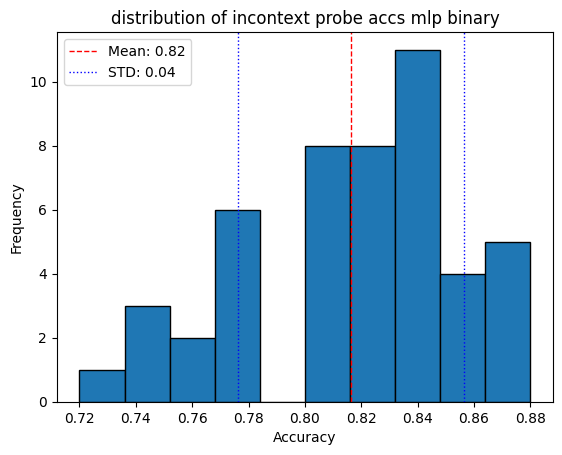

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def histogram(arr, title):

    mean_tqa = np.mean(arr)
    std_tqa = np.std(arr)

    # Plot histogram
    plt.hist(arr, bins=10, edgecolor='black')

    # Add vertical lines for mean and standard deviation
    plt.axvline(mean_tqa, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_tqa:.2f}')
    plt.axvline(mean_tqa - std_tqa, color='b', linestyle='dotted', linewidth=1, label=f'STD: {std_tqa:.2f}')
    plt.axvline(mean_tqa + std_tqa, color='b', linestyle='dotted', linewidth=1)

    # Set title and labels
    plt.title(title)
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')

    # Add a legend
    plt.legend()

    # Show plot
    plt.show()

histogram(all_head_accs_np, title = "distribution of incontext probe accs mlp binary")

In [45]:
# a = -np.sort(-all_head_accs_np.reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), axis = 1)
#layer 21, head 13
px.imshow(np.array(total_accs).reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "Sorted Probe Accuracies on Capitals", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")


In [53]:
nin_d.dataset[98]

{'input': 'Q: What is the capital of Transnistria? A: Georgetown\nQ: What is the capital of Solomon Islands? A: Marigot\nQ: What is the capital of Ghana? A: Managua\nQ: What is the capital of Faroe Islands? A: Tórshavn\nQ: What is the capital of Kuwait? A: Havana\nQ: What is the capital of Iceland? A:',
 'label': 'Reykjavík',
 'n_few_shot': 5,
 'prop_wrong': 0.8752982456752721,
 'n_correct': 1,
 'model_correct': 1}

In [47]:
a = -np.sort(-np.array(total_accs).reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), axis = 1)

px.imshow(a, labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "Sorted Probe Accuracies on Capitals", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")


# Comparing Probes

In [103]:
mlp_bin_probes = torch.load("activations/lbg_bin_mlp_probes.pkl")
attn_bin_probes = torch.load("activations/lbg_bin_attn_probes.pkl")
resid_bin_probes = torch.load("activations/lbg_bin_resid_probes.pkl")
saga_cat_probes = torch.load("activations/saga_probes.pkl")

In [107]:
saga_cat_probes[0].coef_[-1].shape

(1600,)

In [115]:
def compute_probe_cos_sims(a, b):
    #a and b are coefs
    
    cos = nn.CosineSimilarity()
    
    cossims = []
    for p_a, p_b in zip(a, b):
        cossims.append(cos(torch.from_numpy(p_a).reshape(1, -1), torch.from_numpy(p_b).reshape(1, -1)).item())
    
    return np.array(cossims)


bin_coefs = [a.coef_ for a in attn_bin_probes]
cat_coefs = [a.coef_[5] for a in saga_cat_probes]

cossims = compute_probe_cos_sims(bin_coefs, cat_coefs)

px.imshow(np.array(cossims).reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "CosSim of Cat/Bin", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")


In [140]:

# labels = [sample["n_correct"] for sample in dataset]
labels = [1 if sample["n_correct"] == 5 else 0 for sample in nin_d.dataset]

bin_total_accs = []

for i, clf in tqdm(enumerate(attn_bin_probes)):
    acts = [act[i] for act in nin_d.attn_head_acts]
    y_pred = clf.predict(acts)
    
    bin_total_accs.append(accuracy_score(labels, y_pred))


1200it [00:01, 875.99it/s]


In [136]:
np.mean(total_accs), np.std(total_accs)

(0.8048756720430107, 0.023647425764748962)

In [141]:
import math

labels = [1 if sample["n_correct"] == 5 else 0 for sample in nin_d.dataset]

cat_total_accs = []

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

for i, clf in tqdm(enumerate(saga_cat_probes)):
    acts = [act[i] for act in nin_d.attn_head_acts]
    
    outs = np.matmul(acts, clf.coef_[5])
    
    y_pred = [np.round(sigmoid(o)) for o in outs]
    # print(y_pred)
    # y_pred = [np.round(o) for o in y_pred]
    # y_pred = clf.predict(acts)
    # print(y_pred)
    cat_total_accs.append(accuracy_score(labels, y_pred))

1200it [00:02, 530.01it/s]


In [138]:
np.mean(total_accs), np.std(total_accs)

(0.5625672043010753, 0.22491151098731743)

In [144]:
acc_diffs = np.array(cat_total_accs) - np.array(bin_total_accs)

px.imshow(np.array(acc_diffs).reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "AccDiff of Cat/Bin", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")
